In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from lightgbm import LGBMClassifier
import warnings, gc, string, random
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff

init_notebook_mode(connected=True)
color=px.colors.qualitative.Plotly
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))

In [2]:
train_data=pd.read_csv('../input/tabular-playground-series-may-2022/train.csv', index_col='id')
test_data=pd.read_csv('../input/tabular-playground-series-may-2022/test.csv',index_col='id')
submission=pd.read_csv('../input/tabular-playground-series-may-2022/sample_submission.csv')

In [15]:
train_data.head(5)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
id,,,,,,,,,,,,,,,,,,,,,
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,...,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,...,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


In [13]:
print(f"Training data shape: {train_data.shape}")
print(f'missing values: {train_data.isna().sum().sum()}')

Training data shape: (900000, 32)
missing values: 0


In [14]:
train_data.describe()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,target
count,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,...,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000
mean,-0.000286,0.001165,0.001174,-0.001368,-0.000571,0.000284,-0.000709,2.031460,2.057998,2.362431,...,-0.156307,-0.009273,-0.369459,-0.342738,0.176549,0.357591,-0.380876,0.345661,1.002654,0.486488
std,0.998888,0.999193,1.000514,1.000175,1.000167,0.999875,0.999942,1.656172,1.590955,1.637706,...,2.484706,2.450797,2.453405,2.386941,2.416959,2.476020,238.773054,0.475584,0.818989,0.499818
min,-4.599856,-4.682199,-4.642676,-4.658816,-4.748501,-4.750214,-4.842919,0.000000,0.000000,0.000000,...,-13.310146,-11.853530,-12.301097,-11.416189,-11.918306,-14.300577,-1229.753052,0.000000,0.000000,0.000000
25%,-0.675490,-0.675162,-0.674369,-0.676114,-0.675909,-0.673437,-0.674876,1.000000,1.000000,1.000000,...,-1.820063,-1.645585,-2.019739,-1.955956,-1.440424,-1.261598,-159.427418,0.000000,0.000000,0.000000
50%,0.001144,0.002014,0.002218,-0.002227,-0.001662,-0.000438,-0.001492,2.000000,2.000000,2.000000,...,-0.152668,0.030850,-0.390966,-0.340746,0.160912,0.404212,-0.519808,0.000000,1.000000,0.000000
75%,0.674337,0.675021,0.677505,0.672544,0.673789,0.675028,0.674749,3.000000,3.000000,3.000000,...,1.507071,1.661676,1.255408,1.266673,1.795928,2.028219,158.987357,1.000000,2.000000,1.000000
max,4.749301,4.815699,4.961982,4.454920,4.948983,4.971881,4.822668,15.000000,16.000000,14.000000,...,14.455426,11.344080,12.247100,12.389844,12.529179,12.913041,1229.562577,1.000000,2.000000,1.000000


# Exploratory Data Analysis

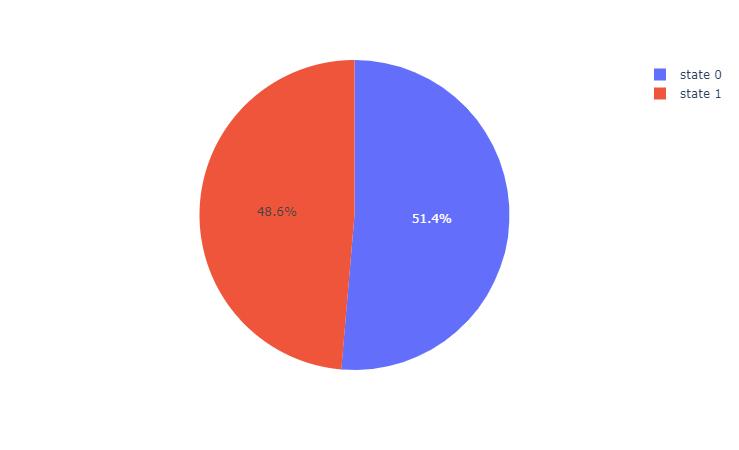

In [25]:
#target distribution
target=train_data.target.value_counts(normalize=True)[::-1]
names=[f'state {i}' for i in target.index]
fig=px.pie(values=target,names=names)
fig.show()

1    0.486488
0    0.513512
Name: target, dtype: float64
